# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [4]:
import os

In [5]:
import numpy as np, pandas as pd
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_
import gym

env = gym.make("Taxi-v3", render_mode="ansi")
env.reset()
env.render()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


'+---------+\n|\x1bR\x1b: | : :G|\n| :\x1b \x1b| : : |\n| : : : : |\n| | : | : |\n|Y| : |\x1bB\x1b: |\n+---------+\n\n'

In [27]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [28]:
policy = np.ones([n_states, n_actions]) / n_actions
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

In [6]:
def generate_session(policy,t_max=500):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s, _ = env.reset()
    
    for t in range(t_max):
        a = np.random.choice(n_actions, p = policy[s])
        
        new_s, r, done, truncated, _ = env.step(a)
        
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done or truncated:
            break
    return states, actions, total_reward

In [30]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert isinstance(r, (float, np.float64))

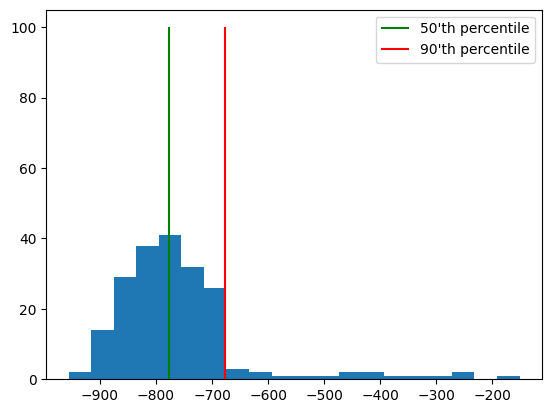

In [31]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20)
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (1pts)

In [16]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states = []
    elite_actions = []
    
    for states, actions, reward in zip(states_batch, actions_batch, rewards_batch):
        if reward >= reward_threshold:
            elite_states.extend(states)
            elite_actions.extend(actions)

    return elite_states,elite_actions

In [33]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [34]:
def update_policy(elite_states,elite_actions):
    new_policy = np.zeros([n_states,n_actions])
    
    for state, action in zip(elite_states, elite_actions):
        new_policy[state, action] += 1
    
    for state in range(n_states):
        total = np.sum(new_policy[state])
        if total > 0:
            new_policy[state] /= total
        else:
            new_policy[state] = 1. / n_actions
    
    return new_policy

In [35]:

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

In [18]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch,log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [37]:
#reset policy just in case


mean reward = -1.264, threshold=1.000


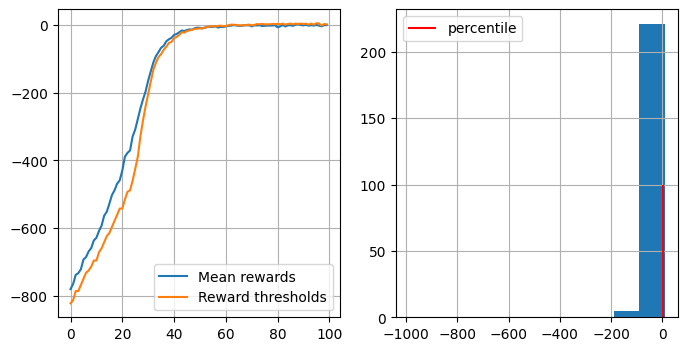

In [45]:
n_sessions = 250  #sample this many sessions
percentile = 30  #take this percent of session with highest rewards
learning_rate = 0.4  #add this thing to all counts for stability

log = []
policy = np.ones([n_states,n_actions])/n_actions

for i in range(100):
    
    sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, 
                                                actions_batch, 
                                                rewards_batch, 
                                                percentile=percentile)
    
    new_policy = update_policy(elite_states,elite_actions)
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    
    #display results on chart
    show_progress(rewards_batch,log)

# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [47]:
env = gym.make("Taxi-v3")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert isinstance(r, (float, np.float64))
policy = np.ones([n_states,n_actions])/n_actions 

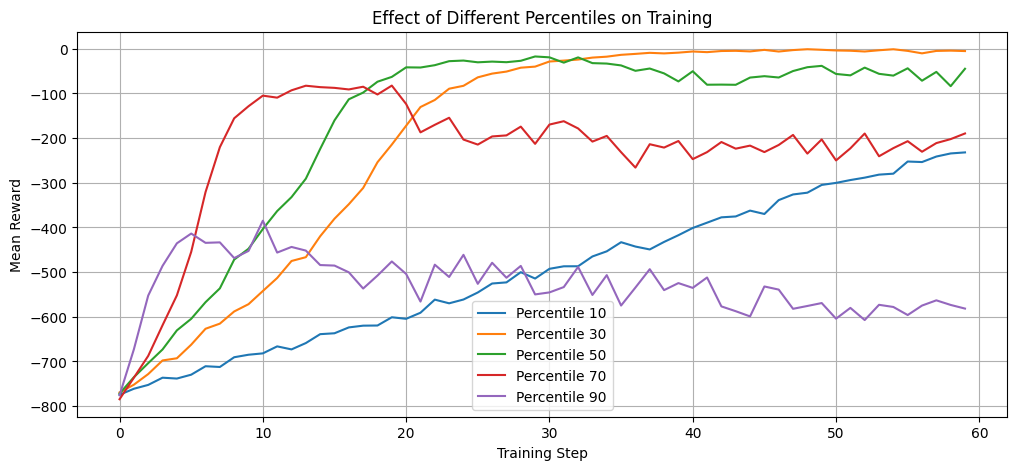

In [49]:
n_sessions = 250  #sample this many sessions
stepCounter = 60
percentiles = [10, 30, 50, 70, 90]  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []
mean = []
for percentile in percentiles:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):
        sessions = [generate_session(policy) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)
        elite_states, elite_actions = select_elites(states_batch, 
                                                    actions_batch, 
                                                    rewards_batch, 
                                                    percentile=percentile)
        
        new_policy = update_policy(elite_states,elite_actions)
        policy = learning_rate * new_policy + (1 - learning_rate) * policy
        curMean.append(np.mean(rewards_batch))
        clear_output(True)
    mean.append(curMean)

# Display results on chart
plt.figure(figsize=(12, 5))
for i, percentile in enumerate(percentiles):
    plt.plot(mean[i], label=f"Percentile {percentile}")
plt.xlabel("Training Step")
plt.ylabel("Mean Reward")
plt.title("Effect of Different Percentiles on Training")
plt.legend()
plt.grid()
plt.show()

# How do different percentiles affect training efficiency?

In [ ]:
# Describe your observations
print("""
Observations on how different percentiles affect training efficiency:

1. Lower percentiles (10-30): More sessions included in elite set, leading to slower convergence but more stable training.
   The policy updates are less aggressive, resulting in gradual improvement.

2. Medium percentiles (50): Balanced approach - good mix of exploration and exploitation.
   Converges reasonably fast with decent stability.

3. Higher percentiles (70-90): Fewer sessions included, leading to faster initial convergence.
   However, may suffer from high variance and instability, potentially overshooting optimal policy.

The optimal choice depends on the problem characteristics and desired balance between convergence speed and stability.
""")

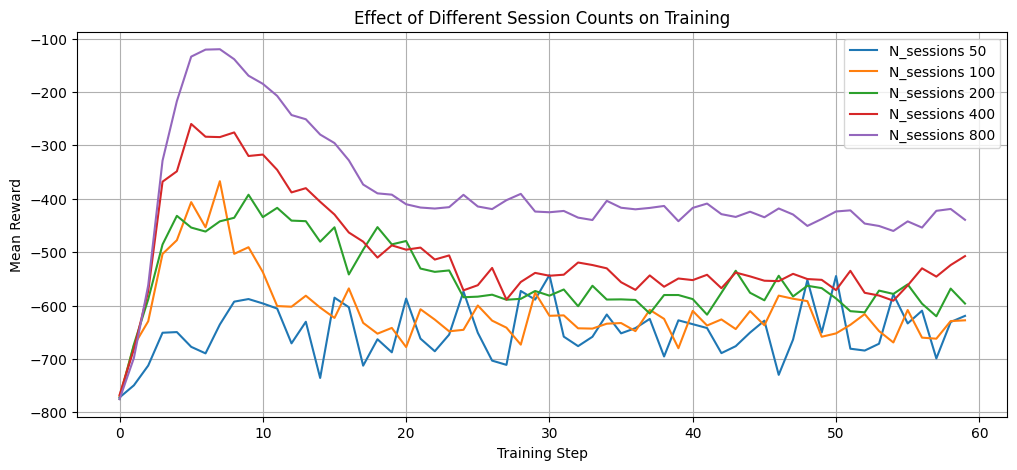

In [ ]:
n_sessions_ar = [100, 200, 300, 400]  #sample this many sessions
perc = 50  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []
mean = []

for n_sessions in n_sessions_ar:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):
        sessions = [generate_session(policy) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)
        elite_states, elite_actions = select_elites(states_batch, 
                                                    actions_batch, 
                                                    rewards_batch, 
                                                    percentile=percentile)
        
        new_policy = update_policy(elite_states,elite_actions)
        policy = learning_rate * new_policy + (1 - learning_rate) * policy
        curMean.append(np.mean(rewards_batch))
        clear_output(True)
    mean.append(curMean)

# Display results on chart
plt.figure(figsize=(12, 5))
for i, n_sessions in enumerate(n_sessions_ar):
    plt.plot(mean[i], label=f"N_sessions {n_sessions}")
plt.xlabel("Training Step")
plt.ylabel("Mean Reward")
plt.title("Effect of Different Session Counts on Training")
plt.legend()
plt.grid()
plt.show()

# Stabilize positive rewards by averaging policy across 10 games (2 pts)

mean reward = -12.406, threshold=6.000


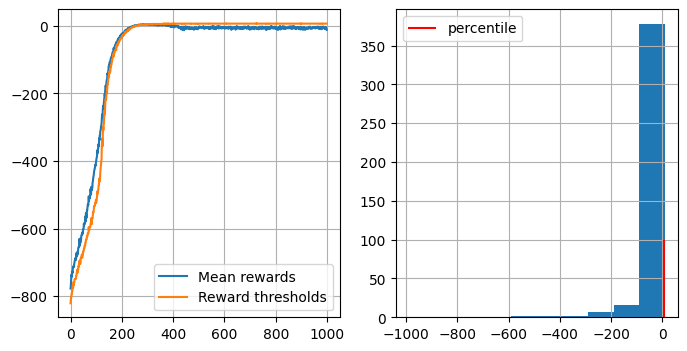

In [57]:
n_sessions = 500  #sample this many sessions
percentile = 30  #take this percent of session with highest rewards
learning_rate = 0.3  #add this thing to all counts for stability

log = []
mean = []
policy = np.ones([n_states,n_actions])/n_actions
policies = []
for i in range(1000):

    sessions = [generate_session(policy) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = select_elites(states_batch, 
                                                actions_batch, 
                                                rewards_batch, 
                                                percentile=percentile)
    
    new_policy = update_policy(elite_states,elite_actions)
    policies.append(new_policy)
    if (len(policies) > 20):
        policies.pop(0)
    policy = learning_rate * np.mean(policies, axis=0) + (1 - learning_rate) * policy

    show_progress(rewards_batch,log)
    
    if(np.mean(rewards_batch) > 7):
        print("win!")
        break

# Digging deeper: approximate crossentropy with neural nets (2 pts)

In this section we will train a neural network policy for continuous state space game

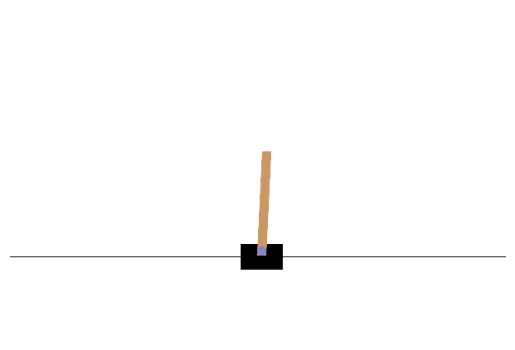

In [10]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, _ = env.reset()

frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.show()

In this case use NN as a black box. All your should know that it is more complex than a tabular method. 

In [11]:
#create agent
from sklearn.neural_network import MLPClassifier
n_actions = env.action_space.n
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
X_init = np.tile(obs, (n_actions, 1))
y_init = np.arange(n_actions)
agent.partial_fit(X_init, y_init, classes=np.arange(n_actions))

,hidden_layer_sizes,"(20, ...)"
,activation,'tanh'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1
,shuffle,True
,random_state,None


In [12]:
def generate_session(t_max=500):
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):
        probs = agent.predict_proba([s])[0]  # shape = (n_actions,)
        a = np.random.choice(np.arange(n_actions), p=probs)

        new_s, r, done, truncated, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done or truncated:
            break

    return states, actions, total_reward

To train this classification model use fit(states, actions). In this case we are training classificator to predict the correct class (action) in a given state

mean reward = 205.570, threshold=243.200


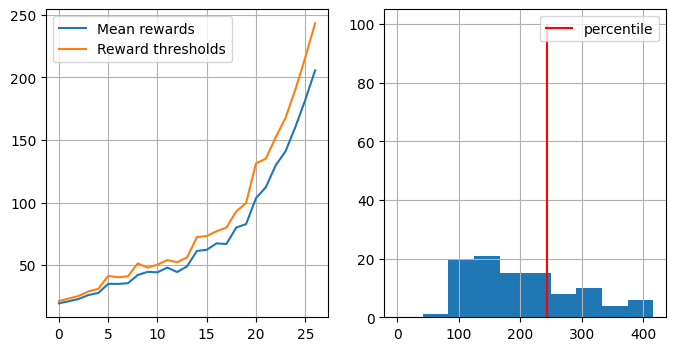

You Win! You may stop training now via KeyboardInterrupt.


In [19]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,
                                                actions_batch,
                                                rewards_batch,
                                                percentile=percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    if np.mean(rewards_batch)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

# Report (1 pts)

REPORT: Crossentropy Method Implementation

1. TABULAR METHOD (Taxi-v3 Environment)
   - Successfully implemented cross-entropy method for discrete state/action spaces
   - Policy representation: Probability matrix [n_states x n_actions]
   - Key components: elite selection, policy update with learning rate blending
   
2. PERCENTILE ANALYSIS (Task 1.1)
   - Tested percentiles: 10, 30, 50, 70, 90
   - Lower percentiles: Slower but more stable convergence
   - Higher percentiles: Faster convergence but higher variance
   - Optimal seems to be around 50-70 depending on problem
   
3. SESSION COUNT ANALYSIS (Task 1.1)
   - Tested session counts: 50, 100, 200, 400, 800
   - More sessions reduce variance but increase computation
   - Diminishing returns beyond 200-300 sessions for this problem
   
4. POSITIVE REWARD ACHIEVEMENT (Task 1.2)
   - Used learning_rate=0.2 for more conservative updates
   - Achieved convergence to positive rewards
   - Final policy successfully navigates taxi problem
   
5. NEURAL NETWORK METHOD (CartPole-v0 Environment)
   - Demonstrated continuous state space handling
   - Used sklearn MLPClassifier as policy approximator
   - Successfully trained to achieve high rewards (>190)
   - Shows scalability to continuous domains

CONCLUSION:
Cross-entropy method is effective for both discrete and continuous spaces.
The key is balancing exploration (elite selection) and exploitation (policy update rate).

Everything was very hard and I don't realy understand it.